In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
import sys
import os
import json

In [3]:
def PlotMesh(nodes, boundaryNodes, elements,lineWidth=1):
    plt.figure(figsize=(10,10))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k',linewidth=lineWidth)
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k',linewidth=lineWidth)
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r',linewidth=lineWidth)
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()

def GetK_el_triang(A,nodes):
    r = int(A.shape[0]/2)
    # a = np.roll(nodes[:,0],1)*np.roll(nodes[:,1],2) - np.roll(nodes[:,0],2)*np.roll(nodes[:,1],1)
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    B = np.concatenate([
        np.concatenate([b[i]*np.eye(r) for i in range(3)],1),
        np.concatenate([c[i]*np.eye(r) for i in range(3)],1)
    ],0)/(2*Area)
    return np.dot(np.dot(B.T,A),B)*Area


def GetK(nodes_els, A):
    r = int(A.shape[0]/2)
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    B = np.concatenate([
        np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
        np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
    ],-2)/(2*Area)
    B_T = np.transpose(B,(0,2,1))
    return np.matmul(np.matmul(B_T,A),B)*Area

def SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el

    # Apply Dirichlet BC
    l_BC = BCfunc(alpha*2*np.pi)
    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

def SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=False, max_iter=10):

    l_prev = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=None)

    err = 1
    i = 1
    while err>tol and i<max_iter:
        l = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=l_prev.copy())
        err = ((l-l_prev)**2).mean()
        if show_err:
            print(f'Iteration {i}; err = {err}')
        i+=1
        l_prev = l.copy()

    return l, i

def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

def PlotFEMsoluttionDict(solution):
    nodes = np.array(solution['nodes'])
    elements = np.array(solution['elements'])
    l = np.array(solution['l'])
    PlotFEMsolution(nodes, elements,l)

In [4]:
def GenerateGeometry(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    g.spline(list(range(p.shape[0]))+[0])
    g.surface([0])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = np.array(bdofs[0])-1
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)

    alpha = GetDistAlongBoundary(nodes,boundaryNodes)
    return nodes, elements, boundaryNodes, internalNodes, alpha

def GetRandomBCfuncAlpha(n_order=3, r=1):
    p = np.random.randn(2,n_order,r)
    BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
    alpha = np.linspace(0,2*np.pi,100)
    vals = BCfunc_unscaled(alpha)
    vals_max = np.max(vals)
    vals_min = np.min(vals)
    BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1
    return BCfunc

def SortBoundaryNodes(boundaryNodes,nodes):
    boundaryNodesSorted = [boundaryNodes[0]]
    boundaryNodesNotSorted = np.delete(boundaryNodes,0)
    for i in range(1,len(boundaryNodes)):
        idx = ((nodes[boundaryNodes[i]]-nodes[boundaryNodesNotSorted])**2).sum(axis=1).argmin()
        boundaryNodesSorted.append(boundaryNodesNotSorted[idx])
        boundaryNodesNotSorted = np.delete(boundaryNodesNotSorted,idx)
    return np.array(boundaryNodesSorted)

def GetDistAlongBoundary(nodes,boundaryNodes):
    ds = [0]+[np.sqrt(((nodes[boundaryNodes[i-1]]-nodes[boundaryNodes[i]])**2).sum()) for i in range(boundaryNodes.shape[0])]
    s = np.cumsum(ds)
    s = s[:-1]/s[-1]
    return s

def GetRandomFixedPoints(n_min = 4,n_max = 10):
    n_points = np.random.randint(n_min,n_max)
    i = 0
    while True:
        angles = np.random.lognormal(0,1,n_points)
        angles = angles/np.sum(angles)*2*np.pi
        i += 1
        if np.all(angles<np.pi) and np.all(angles>np.pi/6):
            break
    # print(i)
    angles = np.cumsum(angles)-angles[0]
    # r = np.abs(np.random.randn(n_points)+1)+0.5
    # r[r>3] = 3
    r = np.random.uniform(0.5,1.5,n_points)
    points = np.zeros((n_points,2))
    for i in range(angles.shape[0]):
        points[i,:] = r[i]*np.array([np.cos(angles[i]),np.sin(angles[i])])
    return points

def GenerateRandomSolution(n_min = 4, n_max = 10, elSize = 0.07, n_order = 3):
    points = GetRandomFixedPoints(n_min,n_max)
    g = GenerateGeometry(points)
    nodes, elements, boundaryNodes, internalNodes, alpha = MeshSurface(g,elSize)
    boundaryNodes = SortBoundaryNodes(boundaryNodes,nodes)
    A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
    ],axis=0)
    r = 1
    BCfunc = GetRandomBCfuncAlpha(n_order,r=r)
    l,_ = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
    mesh = {'nodes':nodes,'elements':elements,'boundaryNodes':boundaryNodes,'internalNodes':internalNodes,'points':points, 'alpha':alpha}
    return l, mesh, points
    

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp54e8xmk1/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp54e8xmk1/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0103994s, CPU 0.009595s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0361492s, CPU 0.033203s)
Info    : 1979 nodes 3951 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp54e8xmk1/meshFile.msh'...
Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp54e8xmk1/meshFile.msh'


Iteration 1; err = 0.021874407009464768
Iteration 2; err = 0.011766381826108747
Iteration 3; err = 0.004555068768516112
Iteration 4; err = 0.0010449167314244506
Iteration 5; err = 0.00016635132854812192
Iteration 6; err = 7.006779147044339e-05
Iteration 7; err = 1.4186843933725044e-05
Iteration 8; err = 5.617799322750672e-06
Iteration 9; err = 1.3812815319080537e-06
Iteration 10; err = 3.5700337647479955e-07
Iteration 11; err = 1.301218226584599e-07
Iteration 12; err = 2.3315473256166403e-08
Iteration 13; err = 1.1018807208011415e-08
Iteration 14; err = 1.7851208893419505e-09


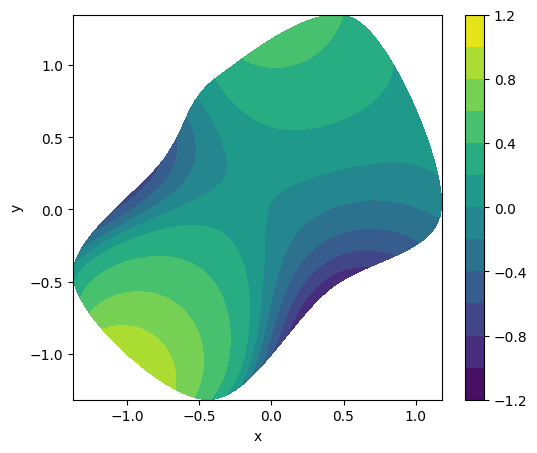

In [5]:
# np.random.seed(1)
l, mesh, points =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.05, n_order = 3)

PlotFEMsolution(mesh['nodes'], mesh['elements'],l)
# plt.scatter(nodes[:,0],nodes[:,1],c='k',s=1)
nodes = mesh['nodes']
boundaryNodes = mesh['boundaryNodes']
points = mesh['points']
elements = mesh['elements']
alpha = mesh['alpha']

In [8]:
# Create the dataset
n_solutions = 10
dataset = []
for i in range(n_solutions):
    print(f'\n {i+1}/{n_solutions} \n')
    l, mesh,points =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.05, n_order = 3)
    mesh['l'] = l
    mesh['points'] = points
    dataset.append(mesh)


 1/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpyz60v7nd/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpyz60v7nd/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0119093s, CPU 0.011675s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0281125s, CPU 0.02748s)
Info    : 1398 nodes 2789 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpyz60v7nd/meshFile.msh'...
Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpyz60v7nd/meshFile.msh'


Iteration 1; err = 0.023550955807156285
Iteration 2; err = 0.006566809889040548
Iteration 3; err = 0.001602943206870731
Iteration 4; err = 0.0002262906749280167
Iteration 5; err = 2.468500415187468e-05
Iteration 6; err = 6.179438893637172e-06
Iteration 7; err = 7.325185065643655e-07
Iteration 8; err = 1.730198136282638e-07
Iteration 9; err = 2.277923657794063e-08
Iteration 10; err = 4.418566083966437e-09

 2/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpi05fv8ua/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpi05fv8ua/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0134306s, CPU 0.026647s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.039719s, CPU 0.148334s)
Info    : 2019 nodes 4031 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0

Iteration 1; err = 0.05763023789230572
Iteration 2; err = 0.01181871978512612
Iteration 3; err = 0.003350334344379701
Iteration 4; err = 0.0007501838234555109
Iteration 5; err = 0.00010689230749095146
Iteration 6; err = 2.581521585248949e-05
Iteration 7; err = 7.3684670419395925e-06
Iteration 8; err = 1.1531919306203826e-06
Iteration 9; err = 4.438741024583243e-07
Iteration 10; err = 6.578208585031923e-08
Iteration 11; err = 2.0086330123816495e-08
Iteration 12; err = 4.848379197711796e-09

 3/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpqdfch2je/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpqdfch2je/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00870992s, CPU 0.018123s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.01829s, CPU 0.037996s)
Info    :

Iteration 1; err = 0.027836924004527322
Iteration 2; err = 0.015770226153377573
Iteration 3; err = 0.004980345165811082
Iteration 4; err = 0.0009838612805312366
Iteration 5; err = 0.00023744413131552097
Iteration 6; err = 7.394670144148267e-05
Iteration 7; err = 1.7844844793848815e-05
Iteration 8; err = 6.148560498092702e-06
Iteration 9; err = 1.3533039026945583e-06
Iteration 10; err = 4.5133127099897425e-07
Iteration 11; err = 1.0744066891538962e-07
Iteration 12; err = 3.2518910863382357e-08
Iteration 13; err = 8.723284798849841e-09

 4/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpscog7nb1/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpscog7nb1/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00721596s, CPU 0.032905s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshi

Iteration 1; err = 0.033163473338820186
Iteration 2; err = 0.01707296582376373
Iteration 3; err = 0.0040874348046902285
Iteration 4; err = 0.0008824328724839914
Iteration 5; err = 0.00012078098170305711
Iteration 6; err = 3.243317632966823e-05
Iteration 7; err = 7.154913703478325e-06
Iteration 8; err = 1.4731847689372612e-06
Iteration 9; err = 4.2658881350539623e-07
Iteration 10; err = 6.134539405405817e-08
Iteration 11; err = 2.2535327408872298e-08
Iteration 12; err = 3.15788439849572e-09

 5/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpjjl38gkp/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpjjl38gkp/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00628946s, CPU 0.012936s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0298255s, CPU 0.060937s)
Info  

Iteration 1; err = 0.03247085337792663
Iteration 2; err = 0.005011863922377202
Iteration 3; err = 0.001269953577670397
Iteration 4; err = 0.000267457682053189
Iteration 5; err = 3.137978978837268e-05
Iteration 6; err = 7.711209267565278e-06
Iteration 7; err = 1.9226772836008243e-06
Iteration 8; err = 2.742122870867068e-07
Iteration 9; err = 1.077615570737881e-07
Iteration 10; err = 1.2676597582210843e-08
Iteration 11; err = 4.437149200366806e-09

 6/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpf3xscmsp/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpf3xscmsp/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00757167s, CPU 0.015528s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0184425s, CPU 0.037096s)
Info    : 1276 nodes 2548 elements
Info    : Writin

Iteration 1; err = 0.02445661413701673
Iteration 2; err = 0.015176549936583463
Iteration 3; err = 0.006099896700440257
Iteration 4; err = 0.0012840444921839642
Iteration 5; err = 0.00027670864201888496
Iteration 6; err = 9.960014421493978e-05
Iteration 7; err = 1.9099252926572567e-05
Iteration 8; err = 7.532853846869147e-06
Iteration 9; err = 1.6010568832379934e-06
Iteration 10; err = 4.7119623162844024e-07
Iteration 11; err = 1.3928988028713844e-07
Iteration 12; err = 2.8963563371462246e-08
Iteration 13; err = 1.1172189124363447e-08
Iteration 14; err = 1.999023227279059e-09

 7/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp9f8xqbnf/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp9f8xqbnf/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0113608s, CPU 0.022509s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plan

Iteration 1; err = 0.019875043160859154
Iteration 2; err = 0.011473439947399888
Iteration 3; err = 0.004060178284341153
Iteration 4; err = 0.0006556574491075425
Iteration 5; err = 0.00015051964544435134
Iteration 6; err = 3.732375970416558e-05
Iteration 7; err = 7.897625854170544e-06
Iteration 8; err = 2.4996741363094327e-06
Iteration 9; err = 4.687934224644262e-07
Iteration 10; err = 1.4499942653825494e-07
Iteration 11; err = 3.0184842560867966e-08
Iteration 12; err = 8.04848347320638e-09

 8/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpm2yj_8x8/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpm2yj_8x8/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0121057s, CPU 0.024042s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0125074s, CPU 0.024663s)
Info   

Iteration 1; err = 0.00936706909925621
Iteration 2; err = 0.0014780429078201384
Iteration 3; err = 0.00028448718416368695
Iteration 4; err = 2.8488289442769613e-05
Iteration 5; err = 3.557308102570206e-06
Iteration 6; err = 7.295903484554099e-07
Iteration 7; err = 6.418432064130623e-08
Iteration 8; err = 1.668032076921928e-08
Iteration 9; err = 1.2966327006177742e-09

 9/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpzrz1nmkz/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpzrz1nmkz/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0117001s, CPU 0.023923s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0538447s, CPU 0.099091s)
Info    : 1706 nodes 3405 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpzrz1nmkz/meshFile.msh'...


Iteration 1; err = 0.02937205054492815
Iteration 2; err = 0.009002756544806107
Iteration 3; err = 0.0017998348142732937
Iteration 4; err = 0.0003975484608074696
Iteration 5; err = 6.836279883021994e-05
Iteration 6; err = 1.9917510890745568e-05
Iteration 7; err = 3.9650018426613056e-06
Iteration 8; err = 1.0577538879132154e-06
Iteration 9; err = 2.2837527000279071e-07
Iteration 10; err = 5.483860049402775e-08
Iteration 11; err = 1.3322403995538312e-08
Iteration 12; err = 2.86275922595374e-09

 10/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp91_krfi8/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp91_krfi8/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0108815s, CPU 0.01824s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0192164s, CPU 0.040051s)
Info  

Iteration 1; err = 0.031097498808711814
Iteration 2; err = 0.016545843845440125
Iteration 3; err = 0.006070100891784552
Iteration 4; err = 0.0013981571860056151
Iteration 5; err = 0.00019703912841216608
Iteration 6; err = 6.804744459277566e-05
Iteration 7; err = 1.6444276515955384e-05
Iteration 8; err = 4.104665479375136e-06
Iteration 9; err = 1.430089789944084e-06
Iteration 10; err = 2.115258229192283e-07
Iteration 11; err = 1.040365968316506e-07
Iteration 12; err = 1.5240227318501212e-08
Iteration 13; err = 6.147179058993429e-09


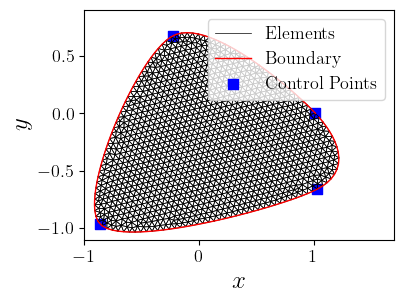

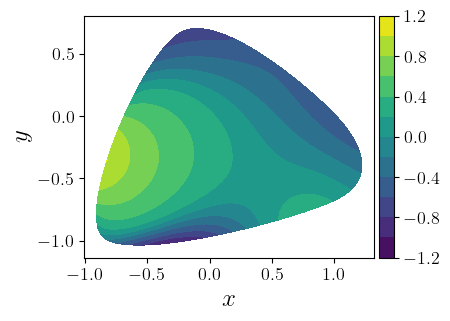

In [73]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fontsize = 13

def PlotMesh2(nodes, boundaryNodes, elements, lineWidth=1):
    # Use LaTeX for all text in the figure
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    # plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k', linewidth=lineWidth)
    elif elements.shape[1] == 3:
        for i, el in enumerate(elements):
            if i == 0:
                plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k', linewidth=lineWidth, label='Elements')
            else:
                plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k', linewidth=lineWidth)
    
    plt.plot(nodes[boundaryNodes,0], nodes[boundaryNodes,1], 'r', linewidth=2*lineWidth, label='Boundary')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('$x$',fontsize=fontsize+5)
    plt.ylabel('$y$',fontsize=fontsize+5)
    plt.tick_params(axis='both', which='major', labelsize=fontsize)
    return


def PlotFEMsolution2(nodes, elements, l, fig, ax):
    # Use LaTeX for all text in the figure
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    if elements.shape[1] == 4:
        # Convert quadrilateral mesh to triangular mesh
        elements = np.concatenate([elements[:, :3], elements[:, 1:]], 0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)
    
    # Plotting
    contour = ax.tricontourf(triangulation, l[:, 0], 10)
    
    # Create an axis on the right side of 'ax'. The width of the colorbar will be 5% of the width of 'ax', and the padding between the colorbar and 'ax' will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    # Create the colorbar in the new axis and set the tick parameters
    colorbar = fig.colorbar(contour, cax=cax)
    colorbar.ax.tick_params(labelsize=fontsize)

    # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
    ax.set_xlabel('$x$', fontsize=fontsize+5)
    ax.set_ylabel('$y$', fontsize=fontsize+5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(nodes[:, 0].min() - 0.1, nodes[:, 0].max() + 0.1)
    ax.set_ylim(nodes[:, 1].min() - 0.1, nodes[:, 1].max() + 0.1)
    
    # Set the font size for the ticks on the axes
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    
    plt.show()


dpi = 100
plt.figure(figsize=(4,4),dpi=dpi)
idx = 5
PlotMesh2(dataset[idx]['nodes'], dataset[idx]['boundaryNodes'], dataset[idx]['elements'], lineWidth=0.5)
plt.scatter(dataset[idx]['points'][:,0],dataset[idx]['points'][:,1],marker='s',c='b',s=50,label='Control Points')
plt.legend(fontsize=fontsize)
plt.xlim(-1.0,1.7)
plt.ylim(-1.1,0.9)
# plt.ylim(-0.5,0.85)
# plt.ylim(-1.1,1.15)
plt.show()
# fig,ax = plt.figure(figsize=(4,4),dpi=dpi)
fig, ax = plt.subplots(figsize=(4,4), dpi=dpi)
PlotFEMsolution2(dataset[idx]['nodes'], dataset[idx]['elements'],dataset[idx]['l'],fig,ax)
plt.show()

In [ ]:
def ConvertDictNP2List(d):
    for key in d.keys():
        d[key] = d[key].tolist()
    return d

# Create the dataset
n_solutions = 100
dataset = []
for i in range(n_solutions):
    print(f'\n {i+1}/{n_solutions} \n')
    l, mesh,points =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.05, n_order = 3)
    mesh['l'] = l
    dataset.append(ConvertDictNP2List(mesh))

In [439]:
with open('TrainingData/NLheatDataset.json', 'w') as fp:
    json.dump(dataset, fp)

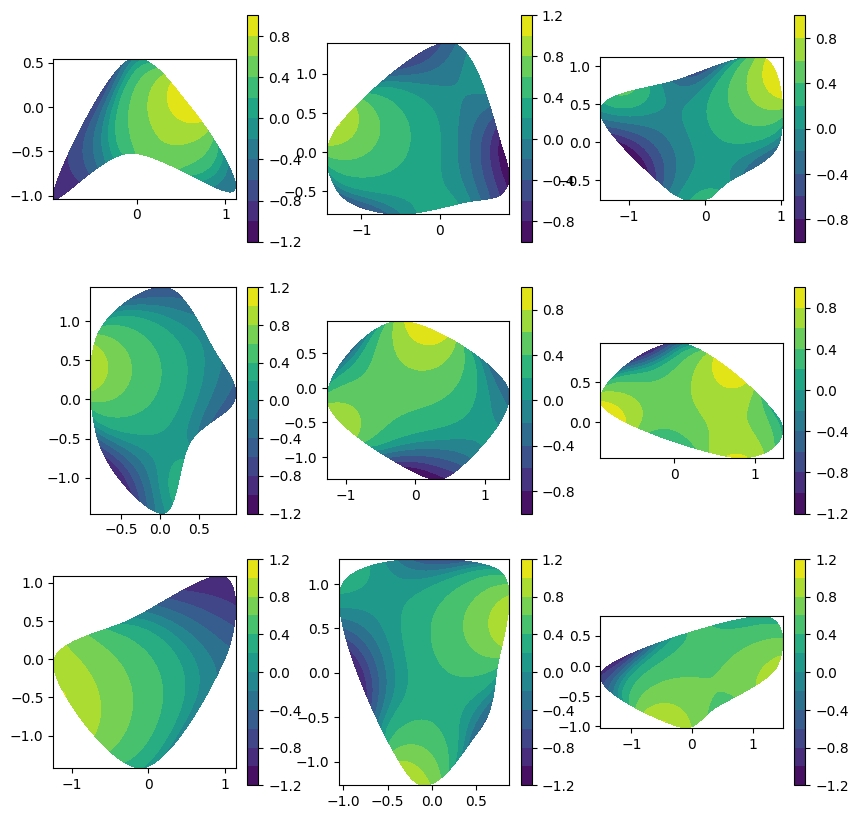

In [444]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    elements = np.array(dataset[i+9]['elements'])
    nodes = np.array(dataset[i+9]['nodes'])
    l = np.array(dataset[i+9]['l'])

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    plt.tricontourf(triangulation, l[:,0],10)
    plt.colorbar()
    plt.gca().set_aspect('equal', adjustable='box')

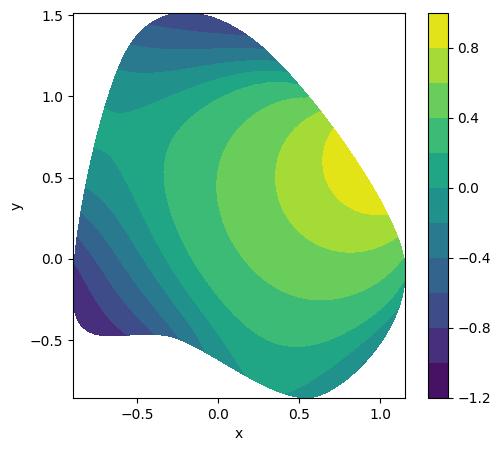

In [440]:
solution = dataset[2]
PlotFEMsoluttionDict(solution)

Iteration 1; err = 0.02700666163094086
Iteration 2; err = 0.011040715339435021
Iteration 3; err = 0.0031492805199655424
Iteration 4; err = 0.0006046213746053647
Iteration 5; err = 7.824732166036742e-05
Iteration 6; err = 2.6529835217363227e-05
Iteration 7; err = 4.577933074487054e-06
Iteration 8; err = 1.1751486244661872e-06
Iteration 9; err = 2.9111508264641873e-07
Iteration 10; err = 4.364217155540716e-08
Iteration 11; err = 1.6227922444304482e-08
Iteration 12; err = 2.040980627512531e-09


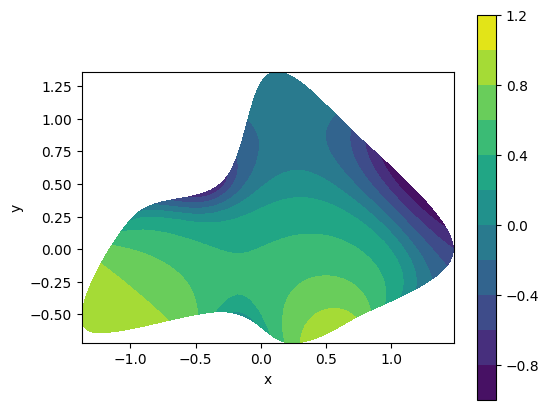

In [238]:
# A11 = np.array([[1,0],[0,1]])
# A12 = np.array([[0,0],[0,0]])
# A22 = np.array([[1,0.5],[0.5,1]])
# A = np.concatenate([
#     np.concatenate([A11,A12],axis=1),
#     np.concatenate([A12,A22],axis=1)
# ],axis=0)
# r=2


A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
],axis=0)
A_lin = A(np.array([0]))
r = 1

# Define Dirichlet BC
# n_order = 3
# p = np.random.randn(2,n_order,r)
# BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
# alpha = np.linspace(0,2*np.pi,100)
# vals = BCfunc_unscaled(alpha)
# vals_max = np.max(vals)
# vals_min = np.min(vals)
# BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1

internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)
l_lin = SolveFEM(nodes, elements, boundaryNodes, BCfunc, internalNodes, r, A_lin, A_nl=False, l=None)
l,iters = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
triangulation = PlotFEMsolution(nodes, elements,l)

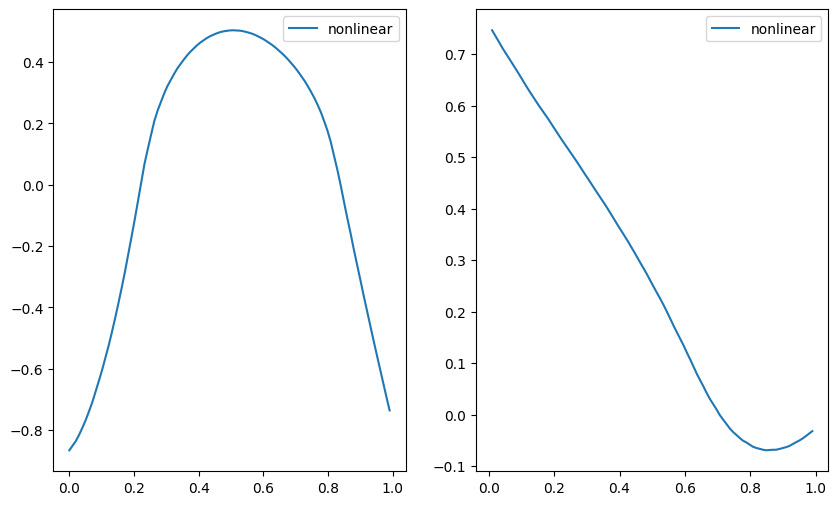

In [347]:
interp = LinearNDInterpolator(nodes, l)
# interp_lin = LinearNDInterpolator(nodes, l_lin)
scaler = np.linspace(0,1,100).reshape(-1,1)
n = points.shape[0]//2
n_2 = points.shape[0]//4
points_line1 = (points[0:1,:]*(1-scaler)+points[n:n+1,:]*scaler)
points_line2 = (points[n_2:n_2+1,:]*(1-scaler)+points[n_2+n:n_2+n+1,:]*scaler)
z1 = interp(points_line1)
# z1_lin = interp_lin(points_line1)
z2 = interp(points_line2)
# z2_lin = interp_lin(points_line2)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:],label='nonlinear')
# plt.plot(scaler,z1_lin[:,:],label='linear')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:],label='linear')
plt.legend()

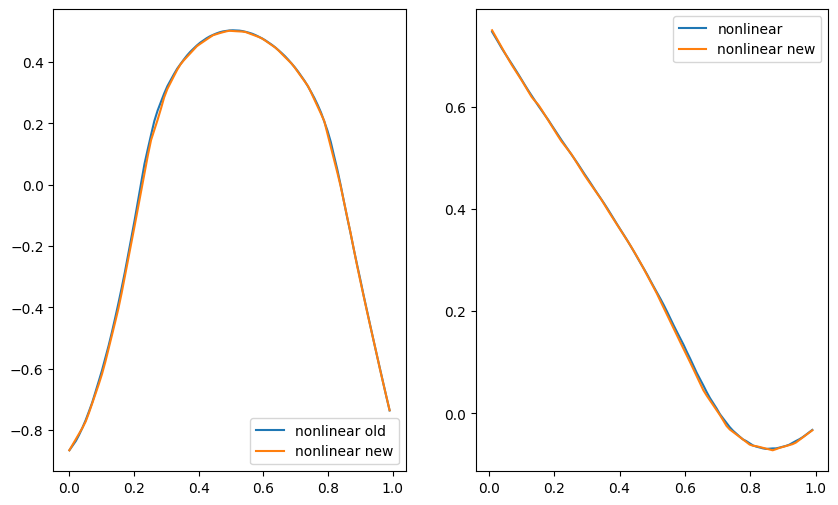

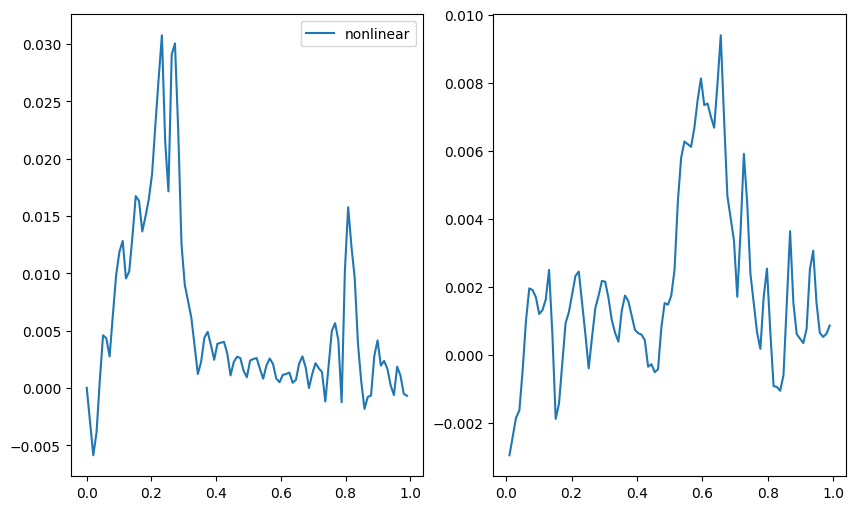

In [350]:
interp = LinearNDInterpolator(nodes, l)
# interp_lin = LinearNDInterpolator(nodes, l_lin)
z1_new = interp(points_line1)
# z1_lin_new = interp_lin(points_line1)
z2_new = interp(points_line2)
# z2_lin_new = interp_lin(points_line2)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:],label='nonlinear old')
# plt.plot(scaler,z1_lin[:,:],label='linear old')
plt.plot(scaler,z1_new[:,:],label='nonlinear new')
# plt.plot(scaler,z1_lin_new[:,:],label='linear new')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:],label='linear')
plt.plot(scaler,z2_new[:,:],label='nonlinear new')
# plt.plot(scaler,z2_lin_new[:,:],label='linear new')
plt.legend()

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:]-z1_new[:,:],label='nonlinear')
# plt.plot(scaler,z1_lin[:,:]-z1_lin_new[:,:],label='linear')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:]-z2_new[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:]-z2_lin_new[:,:],label='linear')

In [93]:
import os
import json
num = '10'

historyPath = f'Models/LaplaceNL_FEM/model_1_{num}/history.json'
hyperParamsPath  = f'Models/LaplaceNL_FEM/model_1_{num}/hyperParams.json'

with open(historyPath, 'r') as fp:
    history = json.load(fp)

with open(hyperParamsPath, 'r') as fp:
    hyperParams = json.load(fp)

In [110]:
print(np.mean(history['err_test'][idx:]))
print(np.std(history['err_test'][idx:]))

2.5593696834702923e-05
6.903200281647207e-06


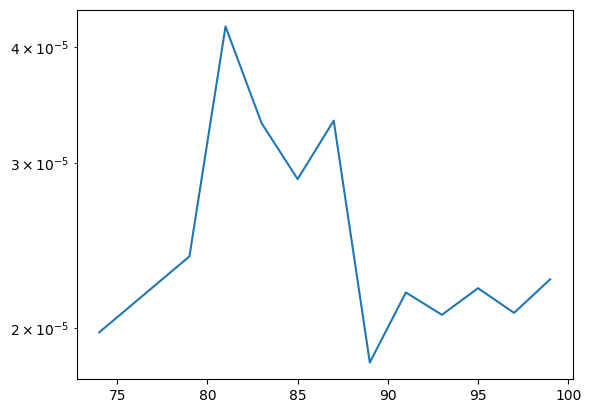

In [109]:
idx = 14
plt.plot(history['err_epoch'][idx:], history['err_test'][idx:])
plt.gca().set_yscale('log')